In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from Bio.Seq import Seq

from torch.nn import functional as F

from netam import pretrained
from netam.models import DEFAULT_NEUTRAL_MODEL

from dnsmex.dxsm_data import pcp_df_of_nickname
from dnsmex.local import localify

figures_dir = localify("FIGURES_DIR")
neutral_model_name = DEFAULT_NEUTRAL_MODEL

### Mutability analysis

In [2]:
def mutability_df_of_mean_mutability(mean_mutability):
    mutability_df = mean_mutability.to_frame()
    mutability_df.columns = ["mutability"]
    mutability_df["nt_site"] = range(1, len(mean_mutability) + 1)
    mutability_df["aa_site"] = (mutability_df["nt_site"] + 2) // 3
    mutability_df = mutability_df[mutability_df["nt_site"] < 350]
    return mutability_df


def plot_mutability_with_highlights(df, aa_sites):
    fig, ax = plt.subplots(figsize=(10, 4))  
    
    ax.plot(df['nt_site'], df['mutability'], label='Mutability', color='gray', alpha=0.7)
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for i, aa_site in enumerate(aa_sites):
        # Extract rows corresponding to the specific amino acid site.
        highlighted = df[df['aa_site'] == aa_site]
        
        ax.scatter(highlighted['nt_site'], highlighted['mutability'], color=colors[i % len(colors)], label=f'AA Site {aa_site}')
    
    ax.set_title('Neutral mutability prediction')
    ax.set_xlabel('Nucleotide Site')
    ax.set_ylabel('Mutability')
    ax.legend()
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    return fig


def single_mut_df_of_csp_logits(csp_logits, aa_site, original_codon):
    per_codon_csps = F.softmax(csp_logits, dim=2).mean(axis=0)[(aa_site-1)*3:aa_site*3]
    per_codon_csps_df = pd.DataFrame(per_codon_csps.detach().numpy(), columns=["A", "C", "G", "T"])

    # Calculate single-mut transition probabilities.
    single_mut_transitions = []
    for i, nt in enumerate(original_codon):
        for mut_nt in "ACGT":
            if mut_nt != nt:
                # Create the mutated codon.
                mutated_codon = original_codon[:i] + mut_nt + original_codon[i+1:]
                # Get the mutation probability.
                prob = per_codon_csps_df.loc[i, mut_nt]
                single_mut_transitions.append((original_codon, mutated_codon, prob, i))

    # Convert single-mut transitions into a DataFrame.
    single_mut_df = pd.DataFrame(single_mut_transitions, columns=['From', 'To', 'Probability', "Mutated_Position"])
    return single_mut_df


def codon_to_aa(codon):
    return str(Seq(codon).translate())


def collect_codon_transitions(our_df, site):
    # Function to translate codon to AA.
    def codon_to_aa(codon):
        try:
            return str(Seq(codon).translate())
        except:
            return None  # Handle invalid codons.
    
    # Calculate codon transitions.
    transitions = our_df.apply(lambda row: (row["parent_heavy"][3*(site-1):3*site], row["child_heavy"][3*(site-1):3*site]), axis=1)
    # Note that in the following code snippet we only use codon_to_aa to test if the codon codes for an AA.
    valid_transitions = transitions[transitions.apply(lambda x: x[0] != x[1] and None not in [codon_to_aa(x[0]), codon_to_aa(x[1])])]
    transition_counts = valid_transitions.value_counts()

    # Translate codons to AAs and format the index.
    transition_counts.index = transition_counts.index.map(lambda t: f"{t[0]} ({codon_to_aa(t[0])}) -> {t[1]} ({codon_to_aa(t[1])})")
    rows_with_transitions = our_df.loc[valid_transitions.index].copy()
    rows_with_transitions["nonsynonymous"] = rows_with_transitions.apply(lambda row: codon_to_aa(row["parent_heavy"][3*(site-1):3*site]) != codon_to_aa(row["child_heavy"][3*(site-1):3*site]), axis=1)
    return rows_with_transitions, transition_counts


class MutabilityContainer:
    def __init__(self, pcp_df, neutral_model_name):
        crepe = pretrained.load(neutral_model_name)
        self.pcp_df = pcp_df
        if len(pcp_df) > 1000:
            self.subset_df = pcp_df.sample(1000)
        else:
            self.subset_df = pcp_df.copy()
        self.rates, self.csp_logits = crepe(self.subset_df["parent_heavy"])
        mean_mutability = pd.Series(self.rates.mean(axis=0))
        self.mutability_df = mutability_df_of_mean_mutability(mean_mutability)
    
    def find_majority_codon(self, aa_site):
        codons = [seq[3*(aa_site-1):3*aa_site] for seq in self.subset_df["parent_heavy"]]
        value_counts = pd.Series(codons).value_counts()
        print("top 5 codons (check to make sure we have a clear majority):")
        print(value_counts[:5])
        return value_counts.index[0]
    
    def plot_mutability_with_highlights(self, aa_sites):
        return plot_mutability_with_highlights(self.mutability_df, aa_sites)

    def codon_transition_probs(self, aa_site, original_codon=None):
        if original_codon is None:
            original_codon = self.find_majority_codon(aa_site)
        single_mut_df = single_mut_df_of_csp_logits(self.csp_logits, aa_site, original_codon)
        mean_rates = self.mutability_df["mutability"].values
        weighted_prob_single = single_mut_df.apply(
            lambda row: row.Probability * mean_rates[3*aa_site + row.Mutated_Position], axis=1)
        single_mut_df['Probability'] = weighted_prob_single / weighted_prob_single.sum()
        return single_mut_df

    def single_codon_transition_df(self, aa_site):
        """
        Build a DataFrame with the single mutation transition probabilities and empirical counts
        for a given amino acid site.
        """
        _, codon_transitions = collect_codon_transitions(self.pcp_df, aa_site)
        
        # Filter to only single nucleotide changes.
        def is_single_nucleotide_change(transition_str):
            # Extract codons from transition string like "ACA (T) -> ATA (I)".
            codons = transition_str.split(' -> ')
            from_codon = codons[0].split(' (')[0]
            to_codon = codons[1].split(' (')[0]
            
            # Count differences.
            differences = sum(c1 != c2 for c1, c2 in zip(from_codon, to_codon))
            return differences == 1
        
        # Filter transitions to single nucleotide changes only.
        single_nt_transitions = codon_transitions[codon_transitions.index.map(is_single_nucleotide_change)]
        
        codon_trans_counts_df = pd.DataFrame({
            "Transition": single_nt_transitions.index, 
            "Counts": single_nt_transitions.values
        })
        codon_trans_counts_df[['Parent AA', 'Child AA']] = codon_trans_counts_df['Transition'].str.extract(
            r'.*\((\w)\) -> .* \((\w)\)'
        )
        codon_trans_counts_df["Synonymous"] = (
            codon_trans_counts_df["Parent AA"] == codon_trans_counts_df["Child AA"]
        )
        
        single_trans_probs = self.codon_transition_probs(aa_site)
        
        # Update the transition strings to include amino acids.
        single_trans_probs['Transition'] = single_trans_probs.apply(
            lambda row: f"{row['From']} ({codon_to_aa(row['From'])}) -> {row['To']} ({codon_to_aa(row['To'])})", 
            axis=1
        )
        
        # Right merge to keep all model predictions and add observed counts where available.
        transitions = pd.merge(
            codon_trans_counts_df, 
            single_trans_probs[['Transition', 'Probability']], 
            on='Transition', 
            how='right'
        )
        
        # Fill missing counts with 0.
        transitions['Counts'] = transitions['Counts'].fillna(0)
        
        # Extract amino acids for all transitions (some may be missing from observed data).
        transitions[['Parent AA', 'Child AA']] = (
            transitions['Transition'].str.extract(r'.*\((\w)\) -> .* \((\w)\)')
        )
        
        transitions["Synonymous"] = (
            transitions["Parent AA"] == transitions["Child AA"]
        )
        
        return transitions

    def plot_single_codon_transitions(self, aa_site, ax, min_count=0):
        """
        Plot single codon transitions for a given amino acid site with counts above a specified minimum.

        Parameters:
        - aa_site: int, the amino acid site to analyze.
        - min_count: int, minimum count of transitions to include in the plot.
        - ax: Matplotlib axis object, the axis to plot on.

        Returns:
        - ax: The axis with the plot.
        """
        # Prepare the data.
        df = self.single_codon_transition_df(aa_site)
        df = df[df["Counts"] >= min_count]
        df["Frequency"] = df["Counts"] / df["Counts"].sum()

        # Extract and sort data.
        df["Parent"] = df["Transition"].str.extract(r'(\w+) \(')
        df = df.sort_values(['Parent', 'Frequency'], ascending=[False, True], kind='mergesort')

        self.plot_codon_transitions_aux(df, ax, show_probabilities=True)
        ax.set_title(f"Single transitions at site {aa_site}")

    def plot_codon_transitions_aux(self, df, ax1, show_probabilities=True, show_labels=True):
        ax2 = ax1.twinx()  # Share the same y-axis.

        if show_probabilities:
            prob_color = "#1b9e77"
        else:
            prob_color = "none"
        counts_color = "#d95f02"

        first_rows = []
        if df["Synonymous"].sum() > 0:
            first_rows.append(df[df["Synonymous"]].index[0])
        if (~df["Synonymous"]).sum() > 0:
            first_rows.append(df[~df["Synonymous"]].index[0])
        first_rows = set(first_rows)

        for index, row in df.iterrows():
            if row['Synonymous']:
                ax1.barh(row['Transition'], -row["Probability"], edgecolor=prob_color, facecolor='none', alpha=0.6, label='Prob. (Synonymous)' if index in first_rows else "")
                ax2.barh(row['Transition'], row['Frequency'], edgecolor=counts_color, facecolor='none', alpha=0.6, label='Counts (Synonymous)' if index in first_rows else "")
            else:
                ax1.barh(row['Transition'], -row["Probability"], color=prob_color, alpha=0.6, label='Neutral probability prediction' if index in first_rows else "")
                ax2.barh(row['Transition'], row['Frequency'], color=counts_color, alpha=0.6, label='Counts (Nonsynonymous)' if index in first_rows else "")

        # Set x-axis limits based on both probability and frequency ranges.
        max_prob = df['Probability'].max() * 1.1  # Add 10% padding
        max_freq = df['Frequency'].max() * 1.1  # Add 10% padding
        
        # Use the larger of the two for the positive side to ensure all bars are visible.
        max_positive = max(max_prob, max_freq)
        ax1.set_xlim(-max_prob, max_positive)

        scale_factor = df['Frequency'].max() / df['Counts'].max()
        
        def modify_tick(tick):
            if tick < 0:
                if show_probabilities:
                    return f"{abs(tick):.2f}"
                else:
                    return ""
            else:
                return f"{tick / scale_factor:.0f}" 

        ticks = ax1.get_xticks()
        ax1.set_xticks(ticks)
        ax1.set_xticklabels([modify_tick(tick) for tick in ticks])
        ax2.set_yticks([])  # Remove right y-axis labels.

        # Set labels for both sides with colors - only if show_labels is True
        if show_labels:
            if show_probabilities:
                # Position labels at the edges of the plot, moved down vertically
                ax1.text(-max_prob/2, -0.12, 'Neutral Probability', transform=ax1.get_xaxis_transform(), 
                         ha='center', va='top', color=prob_color)
                ax1.text(max_positive/2, -0.12, 'Counts', transform=ax1.get_xaxis_transform(), 
                         ha='center', va='top', color=counts_color)
            else:
                ax1.text(max_positive/2, -0.12, 'Counts', transform=ax1.get_xaxis_transform(), 
                         ha='center', va='top', color=counts_color)
        ax2.set_xlabel('Frequency')

        # Make a sorted legend for ax2.
        handles, labels = ax2.get_legend_handles_labels()
        sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
        sorted_handles, sorted_labels = zip(*sorted_handles_labels)
        ax2.legend(sorted_handles, sorted_labels, loc='lower right')

        for tick in ax1.get_yticklabels():
            tick.set_fontname("monospace")

In [3]:
pcp_df = pcp_df_of_nickname("v1rodriguez", add_shm_outputs=False)

pcp_df["v_gene_heavy"].value_counts().head(5)

Loading /Users/matsen/data/v3/rodriguez-airr-seq-race-prod-NoWinCheck_igh_pcp_2024-11-12_MASKED_NI_noN_no-naive.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('sample-igg-SC-18', '440')]


v_gene_heavy
IGHV3-23*01    1905
IGHV3-74*01    1082
IGHV4-39*01    1049
IGHV1-69*01    1025
IGHV3-7*01      909
Name: count, dtype: int64

Loading model ThriftyHumV0.2-59
Using cached models: /Users/matsen/re/netam/netam/_pretrained/thrifty-0.2.0.zip


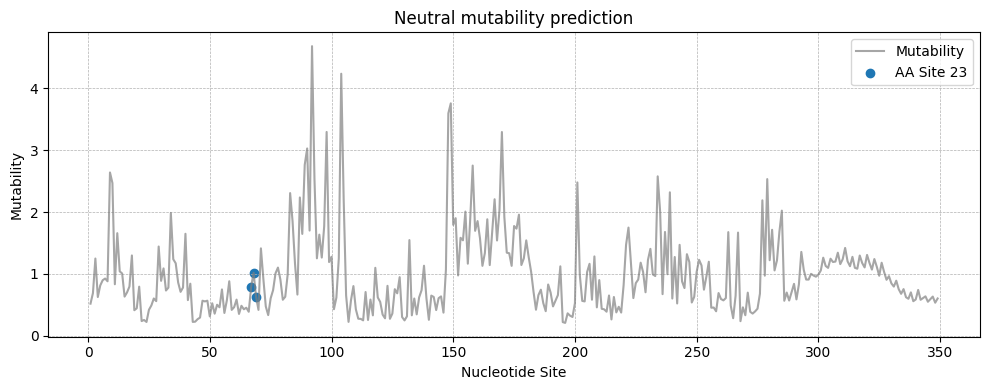

In [4]:
v3_df = pcp_df[pcp_df["v_gene_heavy"] == "IGHV3-23*01"].copy()

mut_v3 = MutabilityContainer(v3_df, neutral_model_name)
fig = mut_v3.plot_mutability_with_highlights([23])

Loading model ThriftyHumV0.2-59
Using cached models: /Users/matsen/re/netam/netam/_pretrained/thrifty-0.2.0.zip


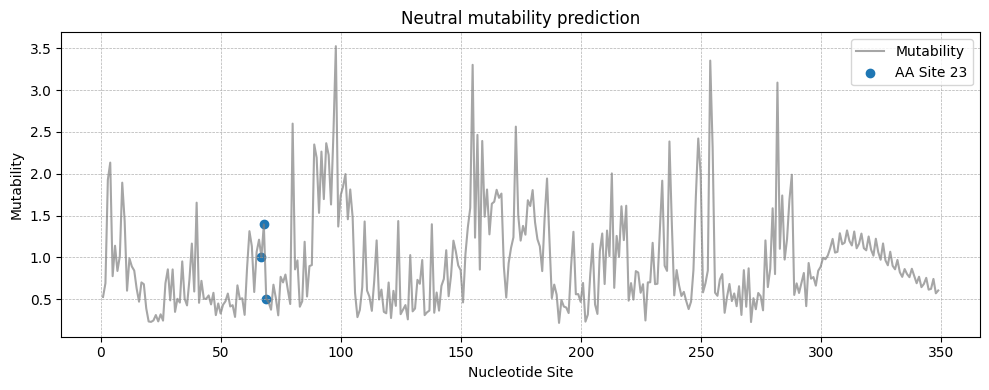

In [5]:
v4_df = pcp_df[pcp_df["v_gene_heavy"] == "IGHV4-39*01"].copy()

mut_v4 = MutabilityContainer(v4_df, neutral_model_name)
fig = mut_v4.plot_mutability_with_highlights([23])

In [6]:
mut_v3.single_codon_transition_df(23)

top 5 codons (check to make sure we have a clear majority):
GCA    815
GTA     55
GAA     25
ACA     22
GGA     20
Name: count, dtype: int64


,Transition,Counts,Parent AA,Child AA,Synonymous,Probability
0,GCA (A) -> ACA (T),37,A,T,False,0.086797
1,GCA (A) -> CCA (P),1,A,P,False,0.039611
2,GCA (A) -> TCA (S),12,A,S,False,0.027099
3,GCA (A) -> GAA (E),24,A,E,False,0.112620
4,GCA (A) -> GGA (G),9,A,G,False,0.168374
5,GCA (A) -> GTA (V),55,A,V,False,0.224298
6,GCA (A) -> GCC (A),1,A,A,True,0.074132
7,GCA (A) -> GCG (A),15,A,A,True,0.202973
8,GCA (A) -> GCT (A),9,A,A,True,0.064097


top 5 codons (check to make sure we have a clear majority):
GCA    815
GTA     55
GAA     25
ACA     22
GGA     20
Name: count, dtype: int64
top 5 codons (check to make sure we have a clear majority):
ACT    722
AGT    112
TCT     40
AAT     29
GCT     26
Name: count, dtype: int64


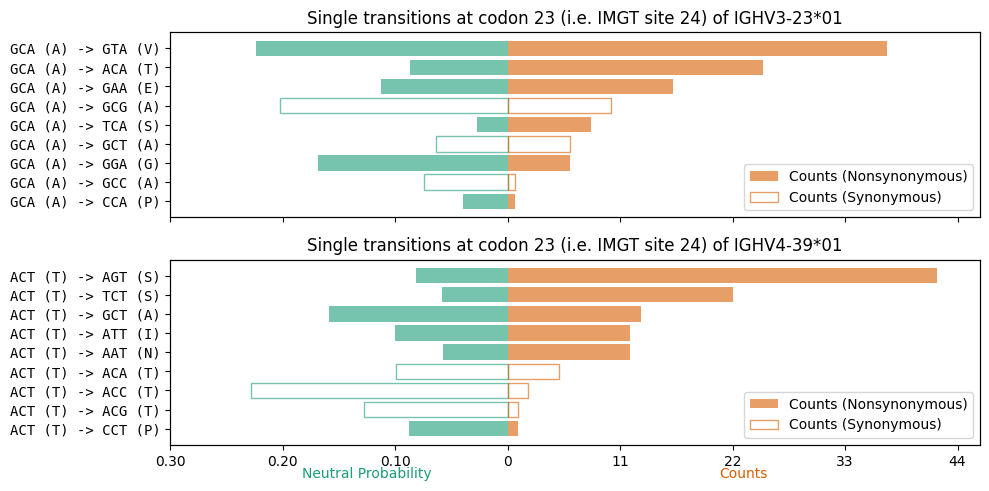

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# For the first plot, we need to prepare the data properly
df_v3 = mut_v3.single_codon_transition_df(23)
df_v3 = df_v3[df_v3["Counts"] >= 0]
df_v3["Frequency"] = df_v3["Counts"] / df_v3["Counts"].sum()
df_v3["Parent"] = df_v3["Transition"].str.extract(r'(\w+) \(')
df_v3 = df_v3.sort_values(['Parent', 'Frequency'], ascending=[False, True], kind='mergesort')

mut_v3.plot_codon_transitions_aux(df_v3, axs[0], show_probabilities=True, show_labels=False)
axs[0].set_title("Single transitions at codon 23 (i.e. IMGT site 24) of IGHV3-23*01")

mut_v4.plot_single_codon_transitions(23, ax=axs[1])
axs[1].set_title("Single transitions at codon 23 (i.e. IMGT site 24) of IGHV4-39*01")

plt.tight_layout()

fig.savefig(figures_dir + f"codon_transitions_23_V34.svg")

### The nonsynonymous mutations at site 23 are not from unacknowledged germline variation

In [8]:
import pandas as pd
import requests
from Bio import SeqIO
from io import StringIO

def parse_fasta_to_df(url):
    response = requests.get(url)
    fasta_string = StringIO(response.text)

    records = list(SeqIO.parse(fasta_string, 'fasta'))

    data = []
    for record in records:
        name = record.id
        sequence = str(record.seq)
        parts = name.split('-')
        family = parts[0]
        rest = '-'.join(parts[1:]) if len(parts) > 1 else ''
        rest = rest.split('*', 1)
        gene = rest[0]
        allele = rest[1] if len(rest) > 1 else ''
        data.append({'name': name, 'sequence': sequence, 'family': family, 'gene': gene, 'allele': allele})

    # Creating DataFrame
    df = pd.DataFrame(data)
    return df

fasta_url = 'https://raw.githubusercontent.com/psathyrella/partis/main/data/germlines/human/igh/ighv.fasta'

# Parsing and displaying the DataFrame
germline_df = parse_fasta_to_df(fasta_url)
site = 23
germline_df[f"{site}th codon"] = germline_df["sequence"].apply(lambda x: x[3*(site-1):3*site])
# make a dataframe of germline_df[f'{site}th codon'].value_counts()
codon_df = germline_df[f"{site}th codon"].value_counts().reset_index()
codon_df
codon_df[f"{site}th AA"] = codon_df[f"{site}th codon"].apply(codon_to_aa)
codon_df
# reorder with count last
codon_df = codon_df[[f"{site}th codon", f"{site}th AA", "count"]]
codon_df

,23th codon,23th AA,count
0,GCA,A,87
1,AAG,K,52
2,ACT,T,23
3,GCT,A,17
4,ACC,T,11
5,ACA,T,3
6,TCA,S,3
7,GCC,A,2


In [9]:
germline_df[germline_df["23th codon"] == "TCA"]

,name,sequence,family,gene,allele,23th codon
120,IGHV3-64D*06,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,IGHV3,64D,06,TCA
121,IGHV3-64D*08,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,IGHV3,64D,08,TCA
122,IGHV3-64D*09,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,IGHV3,64D,09,TCA


In [10]:
germline_df[germline_df["name"].str.startswith("IGHV3-64D")]

,name,sequence,family,gene,allele,23th codon
120,IGHV3-64D*06,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,IGHV3,64D,06,TCA
121,IGHV3-64D*08,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,IGHV3,64D,08,TCA
122,IGHV3-64D*09,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,IGHV3,64D,09,TCA


## Buried vs exposed analysis

In [11]:
# Below we skip 118 because it's not encoded by the V gene, and 52 because it's a W amino acid that has only one codon (doesn't make sense to do syn/nonsyn comparison).
buried_sites, exposed_sites = ([87, 78, 105, 76], [16, 9, 8, 7])

numbering_5i19 = pd.read_csv("../../data/5i19_numbering_scheme.csv")
# numbering_5i19.head().to_clipboard()

buried_dict = {}
for imgt_site in buried_sites:
    row = numbering_5i19[numbering_5i19.imgt_site == imgt_site].iloc[0]
    buried_dict[imgt_site] = row.site

exposed_dict = {}
for imgt_site in exposed_sites:
    row = numbering_5i19[numbering_5i19.imgt_site == imgt_site].iloc[0]
    exposed_dict[imgt_site] = row.site

def plot_codon_transitions_stack(site_dict):
   """Create a stack of plots for all sites in the dictionary."""
   n_sites = len(site_dict)
   fig, axes = plt.subplots(n_sites, 1, figsize=(10, 3 * n_sites))
   
   for i, (imgt_site, regular_site) in enumerate(site_dict.items()):
       mut_v3.plot_single_codon_transitions(regular_site, ax=axes[i], min_count=0)
       axes[i].set_title(f"Single transitions at codon {regular_site} (i.e. IMGT site {imgt_site}) of IGHV3-23*01")
       
       # # Suppress x-axis labels for all except the bottom plot
       if i < n_sites - 1:
           axes[i].set_xlabel("")
   
   plt.tight_layout()
   return fig

top 5 codons (check to make sure we have a clear majority):
CTG    648
GTG    112
CTC     47
TTG     47
CTA     37
Name: count, dtype: int64
top 5 codons (check to make sure we have a clear majority):
ATC    850
GTC     82
ATT     19
ATG     14
ACC     12
Name: count, dtype: int64
top 5 codons (check to make sure we have a clear majority):
GCG    836
GTG     60
ACG     30
GCC     22
GCA     16
Name: count, dtype: int64
top 5 codons (check to make sure we have a clear majority):
TTC    961
GTC     13
CTC     11
TTT      9
TAC      4
Name: count, dtype: int64


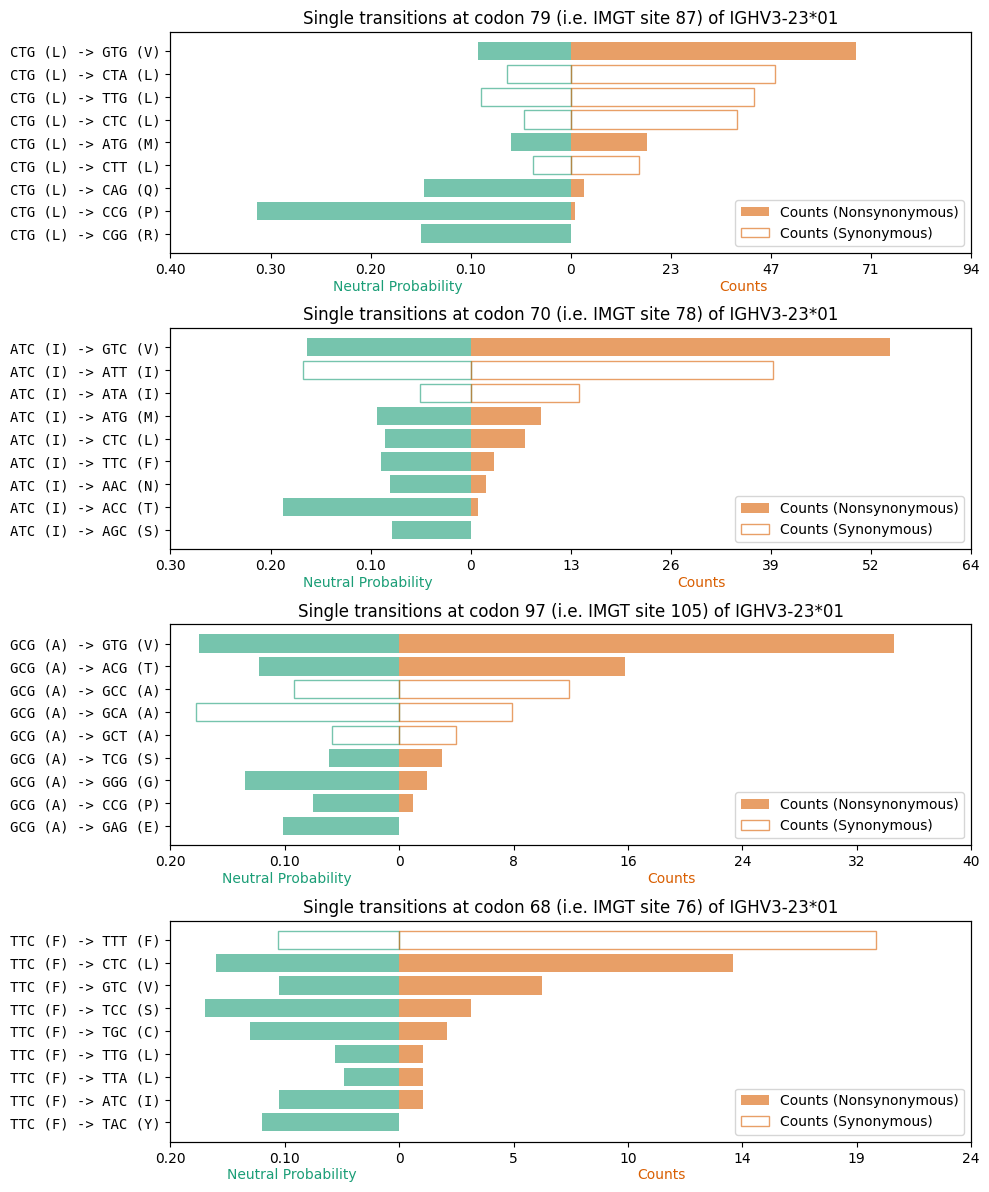

In [12]:
buried_fig = plot_codon_transitions_stack(buried_dict)
buried_fig.savefig(figures_dir + "codon_transitions_buried_V3.svg")

top 5 codons (check to make sure we have a clear majority):
GGG    975
GGA     18
GGT      4
GCG      2
GAG      1
Name: count, dtype: int64
top 5 codons (check to make sure we have a clear majority):
GGA    990
GGC      4
GGG      3
CAA      2
GAA      1
Name: count, dtype: int64
top 5 codons (check to make sure we have a clear majority):
GGG    984
GGA     12
GAG      3
GGC      1
Name: count, dtype: int64
top 5 codons (check to make sure we have a clear majority):
TCT    959
TCG     31
TCC      5
TTT      3
ACT      2
Name: count, dtype: int64


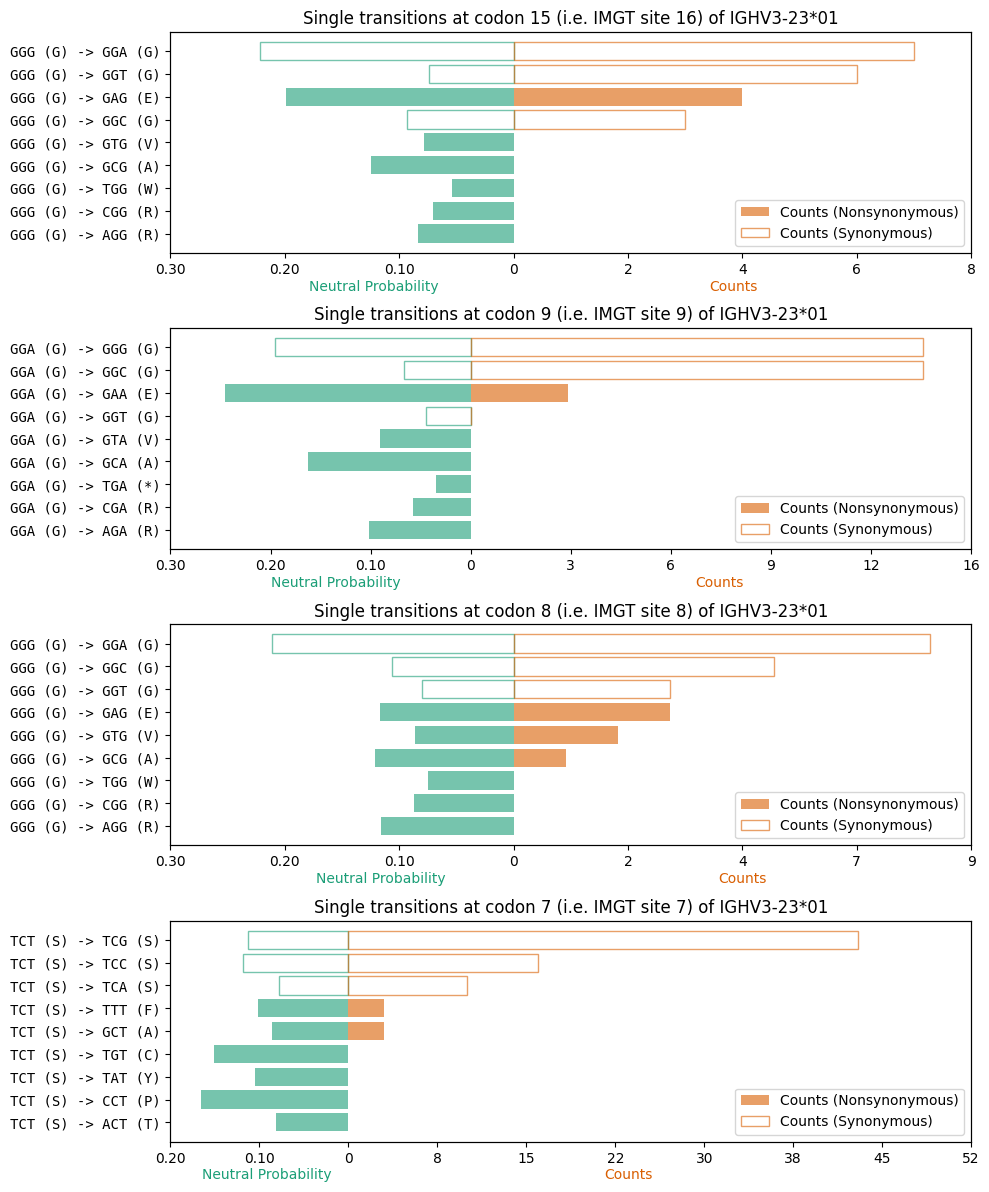

In [13]:
exposed_fig = plot_codon_transitions_stack(exposed_dict)
exposed_fig.savefig(figures_dir + "codon_transitions_exposed_V3.svg")

top 5 codons (check to make sure we have a clear majority):
CTG    648
GTG    112
CTC     47
TTG     47
CTA     37
Name: count, dtype: int64


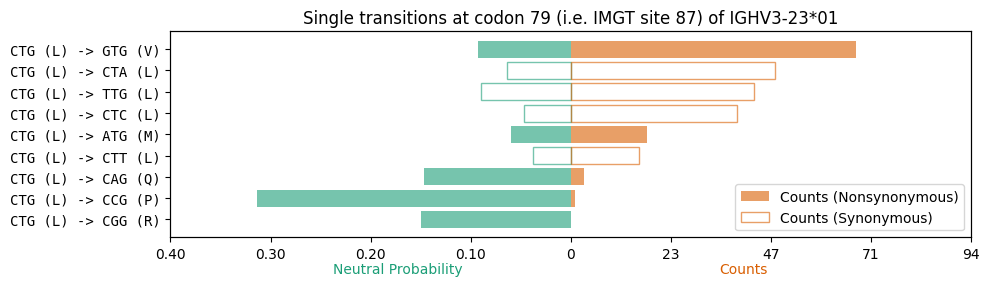

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

mut_v3.plot_single_codon_transitions(79, ax=ax)
ax.set_title("Single transitions at codon 79 (i.e. IMGT site 87) of IGHV3-23*01")

plt.tight_layout()

fig.savefig(figures_dir + f"codon_transitions_79_V3.svg")